# Python_DeepLearning_Pytorch - part4
#### 딥러닝과 파이토치와 관련된 기본적인 내용을 정리하였습니다. 파이썬 딥러닝 파이토치(이경택, 방성수, 안상주 지음)을 참고하였습니다. 
#### GPU 사용을 위해서 google colab을 활용하여 작성하였습니다.

## 4. 컴퓨터 비전
#### 컴퓨턴 비전 Task에 모델을 적용하려면 딥러닝 모델 중 CNN을 사용해야 한다. CNN이 이미지의 feature를 잘 뽑을 수 있도록 특화돼 있는 모델이기 때문이다.

#### 예제 4.1 CIFAR-10 데이터를 이용해 MLP 설계하기
#### 1. 모듈 임포트
#### 2. 장비 확인
#### 3. 데이터 다운로드(train, test 분리)
#### 4. 데이터 확인 (1)
#### 5. 데이터 확인 (2)
#### 6. MLP 모델 설계
#### 7. Optimizer, objective function 설정
#### 8. 학습데이터에 대한 모델의 성능 확인 함수 정의 
#### 9. 검증데이터에 대한 모델의 성능 확인 함수 정의
#### 10. train, test set의 loss 및 test set accuracy 확인

In [ ]:
#### 1. 모듈 임포트 
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets 

In [ ]:
#### 2. 딥러능 모델을 설계할 때 활용하는 장비 확인
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print('Using pytorch vesion: ', torch.__version__, 'device : ', DEVICE)

BATCH_SIZE = 32
EPOCHS = 10

Using pytorch vesion:  1.8.1+cu101 device :  cuda


In [ ]:
#### 3. CIFAR10 데이터 다운로드(train, test 분리)
train_dataset = datasets.CIFAR10(root = '../data/CIFAR_10', train = True, download = True, transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root = '../data/CIFAR_10', train = False, transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=BATCH_SIZE, shuffle = False)


Extracting ../data/CIFAR_10/cifar-10-python.tar.gz to ../data/CIFAR_10


In [ ]:
#### 4. 데이터 확인하기 (1)
for (X_train, y_train) in train_loader:
  print('X_train: ', X_train.size(), 'type: ', X_train.type())
  print('y_train: ', y_train.size(), 'type: ', y_train.type())
  break

X_train:  torch.Size([32, 3, 32, 32]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor


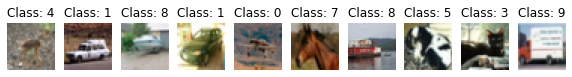

In [ ]:
#### 5. 데이터 확인하기 (2)
pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize))

for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(np.transpose(X_train[i], (1,2,0)))
  plt.title('Class: ' + str(y_train[i].item()))

In [ ]:
#### 6. MLP 모델 설계하기 
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(32 * 32 *3 , 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)

  def forward(self, x):
    x = x.view(-1, 32*32*3)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.log_softmax(x, dim = 1)
    return x

In [ ]:
#### 7. Optimizer, Objective function 설정
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [ ]:
#### 8. 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{} / {} ({:.0f} %)]\tTrain Loss: {:.6f}'.format(Epoch, batch_idx * len(image),
                                                                              len(train_loader.dataset), 100 * batch_idx / len(train_loader), loss.item()))

In [ ]:
#### 9. 검증 데이터에 대한 모델 성능을 확인하는 함수 정으 ㅣ
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += prediction.eq(label.view_as(prediction)).sum().item()
  test_loss /= len(test_loader.dataset)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [ ]:
#### 10. MLP 학습을 실행하며 train, test loss 및 test set accuracy 확인
for Epoch in range(1, EPOCHS + 1):
  train(model, train_loader, optimizer, log_interval= 200)
  test_loss, test_accuracy = evaluate(model, test_loader)
  print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0 / 50000 (0 %)]	Train Loss: 2.304254
Train Epoch: 1 [6400 / 50000 (13 %)]	Train Loss: 1.800380
Train Epoch: 1 [12800 / 50000 (26 %)]	Train Loss: 1.991248
Train Epoch: 1 [19200 / 50000 (38 %)]	Train Loss: 1.546349
Train Epoch: 1 [25600 / 50000 (51 %)]	Train Loss: 1.828424
Train Epoch: 1 [32000 / 50000 (64 %)]	Train Loss: 1.787461
Train Epoch: 1 [38400 / 50000 (77 %)]	Train Loss: 1.577772
Train Epoch: 1 [44800 / 50000 (90 %)]	Train Loss: 1.582009

[EPOCH: 1], 	Test Loss: 0.0520, 	Test Accuracy: 41.12 % 

Train Epoch: 2 [0 / 50000 (0 %)]	Train Loss: 1.621955
Train Epoch: 2 [6400 / 50000 (13 %)]	Train Loss: 1.788679
Train Epoch: 2 [12800 / 50000 (26 %)]	Train Loss: 1.803177
Train Epoch: 2 [19200 / 50000 (38 %)]	Train Loss: 1.666388
Train Epoch: 2 [25600 / 50000 (51 %)]	Train Loss: 1.516945
Train Epoch: 2 [32000 / 50000 (64 %)]	Train Loss: 1.471592
Train Epoch: 2 [38400 / 50000 (77 %)]	Train Loss: 1.468753
Train Epoch: 2 [44800 / 50000 (90 %)]	Train Loss: 1.728194

[EPOCH: 

#### 예제 4.2 CIFAR-10 데이터를 이용해 CNN 설계

In [ ]:
#### 6. CNN 모델 설계하기
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(       #### 2차원 이미지 데이터를 nn.Conv2d 메서드를 이용해 Convolution 연산을 하는 filter 정의
        in_channels = 3,          #### 이미지에 하는 convolution 연산은 채널 수를 이미지의 채널 수와 맞춰줌
        out_channels = 8,         #### convolution 연산을 하는 filter의 개수를 설정 - ouput의 depth가 결정
        kernel_size = 3,          #### filter의 크기를 설정 
        padding = 1
    )
    self.conv2 = nn.Conv2d(
        in_channels = 8,                
        out_channels = 16, 
        kernel_size = 3, 
        padding = 1
    )
    self.pool = nn.MaxPool2d(
        kernel_size = 2, 
        stride = 2
    )
    self.fc1 = nn.Linear(8*8*16, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool(x)

    x = x.view(-1, 8*8*16)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.log_softmax(x)
    return x

#### 예제 4.3 CIFAR-10 데이터에 Augmentaion 기법을 이용해 모델의 성능 향상시키기

In [ ]:
#### 3. Data Augmentaion이 적용된 CIFAR10 데이터 다운로드(train, test 분리)
train_dataset = datasets.CIFAR10(root = '../data/CIFAR_10', train = True, download = True, 
                                transform = transforms.Compose([                                          #### transforms.Compose - 불러오는 이미지 데이터에 전처리 및 Augmentaion 적용
                                                                transforms.RandomHorizontalFlip(),        #### 50% 확률로 좌우 반전
                                                                transforms.ToTensor(),
                                                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]))     #### 평균과 표준편차 모두 0.5로 통일    
test_dataset = datasets.CIFAR10(root = '../data/CIFAR_10', train = False,
                                transform = transforms.Compose([                                          #### transforms.Compose - 불러오는 이미지 데이터에 전처리 및 Augmentaion 적용
                                                                transforms.RandomHorizontalFlip(),        #### 50% 확률로 좌우 반전
                                                                transforms.ToTensor(),
                                                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]))     #### 평균과 표준편차 모두 0.5로 통일)
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=BATCH_SIZE, shuffle = False)

Files already downloaded and verified


#### 예제 4.4 CIFAR-10 데이터에 고급 CNN 모델을 적용해 성능 향상시키기

In [1]:
#### 6. ResNet 모델 설계하기
class BasicBlock(nn.Module):    #### resnet은 반복적으로 이용하는 block을 바탕으로 구성되므로 해당 block을 먼저 정의
  def __init__(self, in_planes, planes, stride = 1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3,
                           stride = stride, padding = 1, bias = False)    #### in_planes - input으로 이용되는 데이터의 채널 수, kernel_size - flter의 크기
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, 
                           stride = 1, padding = 1, bias = False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != planes:
      self.shortcut = nn.Sequential(nn.Conv2d(in_planes, planes, kernel_size = 1, 
                                              stride = stride, bias = False), 
                                    nn.BatchNorm2d(planes))    #### Shorcut은 기존의 값과 Convolution 및 Batch Normalization한 결과를 더하는 과정
    
    def forward(self, x):
      out = F.relu(self.bn1(self.conv1(x)))
      out = self.bn2(self.conv2(out))
      out += self.shortcut(x)    #### skip connction
      out = F.relu(out)
      return out


  class ResNet(nn.Module):
    def __init__(self, num_classes = 10):
      super(ResNet, self).__init__()
      self.in_planes = 16
      self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1, bias = False)
      self.bn1 = nn.BatchNorm2d(16)
      self.layer1 = self._make_layer(16, 2, stride = 1)
      self.layer2 = self._make_layer(32, 2, stride = 2)
      self.layer3 = self._make_layer(64, 2, stride = 2)
      self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
      strides = [stride] + [1] * (num_blocks - 1)
      layers = []
      for stride in strides:
        layers.append(BasicBlock(self.in_planes, planes, stride))
        self.in_planes = planes
      return nn.Sequential(*layers)

    def forward(self, x):
      out = F.relu(self.bn1(self.conv1(x)))
      out = self.layer1(out)
      out = self.layer2(out)
      out = self.layer3(out)
      out = F.avg_pool2d(out, 8)    #### average pooling
      out = out.view(out.size(0), -1)
      out = self.linear(out)
      return out

NameError: ignored

#### 예제 4.5 CIFAR-10 데이터에 대표적인 딥러닝 모델을 불러와 적용하기

In [ ]:
#### 6. 파이토치 내에서 제공하는 ResNet34 모델 불러온 후 FC 층 추가 및 Output 크기 설정
import torchvision.models as models
model = models.resnet34(pretrained = False)    #### resnet34 모델을 불러옴 / 모델 구조가 imagenet 데이터에 미리 학습한 파라미터는 불러오지 않음
num_ftrs = model.fc.in_features                #### resnet34 모델에 대해 fully connected layer를 구성하는 input 노드 수를 저장
model.fc = nn.Linear(num_ftrs, 10)
model = model.cuda()

#### 예제 4.6 대용량의 데이터를 이용해 학습이 완료된 모델을 적은 수의 데이터게 맞게 Fine-tuning하는 Transfer Learning 실습하기
#### 1. 모듈 임포트 
#### 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인
#### 3. 데이터 불러오기(train, test 분리)
#### 4. 데이터 확인하기 (1)
#### 5. 데이터 확인하기 (2)
#### 6. 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
#### 7. 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
#### 8. 미리 학습되지 않은 resnet18 모델을 불러온 후 output 크기 설정
#### 9. optimizer, objective 설정
#### 10. resnet18 학습을 실행하고, train, test의 loss 및 test set accuracy 확인
#### 11. fine-tuning

In [2]:
#### 1. 모듈 임포트 
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [4]:
#### 2. 딥러니 모델을 설계할 때 활용하는 장비 확인
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cpu')

print('Using pytorch version:', torch.__version__, 'Device: ', DEVICE)

BATCH_SIZE = 32
EPOCHS = 10

Using pytorch version: 1.8.1+cu101 Device:  cuda


In [ ]:
#### 3. 개미와 벌을 분류하기 위한 데이터 불러오기(train, test 분리)
data_transforms = {
    'train' : transforms.Compose([
                                  transforms.RandomResizedCrop(224),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val' : transforms.Compose([
                                transforms.CenterCrop(224),
                                transforms.Resize(256), 
                                transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

image_datasets = {x : datasets.ImageFolder("../data/hymenoptera_data", 
                                           data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size= BATCH_SIZE, num_workers=0, shuffle=True) for x in ['train', 'val']}

In [ ]:
#### 4. 데이터 확인하기 (1)
for (X_train, y_train) in dataloaders['train']:
  print("X_train: ", X_train.size(), 'type:', X_train.type())
  print("y_train: ", y_train.size(), 'type:', y_train.type())
  break

In [ ]:
#### 5. 데이터 확인하기 (2)
pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize))

for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(np.transpose(X_train[i], (1,2,0)))
  plt.title('Class: ' + str(y_train[i].item()))

In [ ]:
#### 6. 불러온 특정 모델에 대해 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval):
  model.train()
  for batch_idx, (image, label) in enumerate(train_loader):
    image = image.to(DEVICE)
    label = label.to(DEVICE)
    optimizer.zero_grad()
    output = model(image)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()

    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{}({:0.f}%)]\tTrain Loss: {:.6f}'.format(
          Epoch, batch_idx * len(image), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()
      ))

In [ ]:
#### 7. 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item()
      prediction = output.max(1, keepdim = True)[1]
      correct += predcition.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [ ]:
#### 8. 파이토치 내에서 제공하는 학습되지 않은 resnet18 모델을 불러온 후 output 크기 설정
import torchvision.models as models
model = models.resnet18(pretrained = False).cuda()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

In [ ]:
#### 9. optimizer, objective 설정
optimizer = torch.optim.Adam(moel.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

print(model)

In [ ]:
#### 10. resnet18 학습을 실행하며 train, test loss 및 test accuracy 확인
for Epoch in range(1, EPOCHS + 1):
  train(model, dataloaders['train'], optimizer, log_interval = 5)
  test_loss, test_accuracy = evaluate(model, dataloaders['val'])
  print('\n[Epoch: {}], \tTest Loss: {:.f4}, \tTest Accuracy: {:.2f} % \n'.formate(Epoch, test_loss, test_accuracy))

In [ ]:
#### 11. fine tuning
model = models.resnet18(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,2)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
EPOCHS = 10
for epoch in range(1, EPOCHS + 1):
  train(model, dataloaders['train'], optimizer, log_interval = 5)
  valid_loss, valid_accuracy = evaluate(model, dataloaders['val'])
  print('\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n'.format(epoch, valid_loss, valid_accuracy))